# Loading and Preprocessing Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
dataset_path='/content/drive/MyDrive/boneage-training-dataset'
csv_file_path='/content/drive/MyDrive/boneage-training-dataset.csv'

In [ ]:
import os
import numpy as np
from tqdm import tqdm
import pandas as pd
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import preprocess_input
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression


In [ ]:
df = pd.read_csv(csv_file_path)

In [ ]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

In [ ]:
df.head()

,id,boneage,male
0,1377,180,False
1,1378,12,False
2,1379,94,False
3,1380,120,True
4,1381,82,False


In [ ]:
df.shape

(12611, 3)

<Axes: xlabel='male', ylabel='count'>

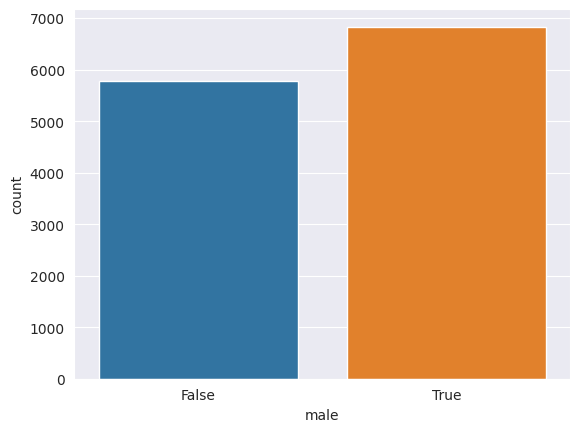

In [ ]:
sns.set_style("darkgrid")
sns.countplot(df,x="male")

In [ ]:
px.histogram(df,x='boneage')

In [ ]:
df_test=pd.read_csv('/content/drive/MyDrive/boneage-test-dataset.csv')

In [ ]:
ra=[]
for  i in range(187):
  if i%12==5 or i%12==6 or i%12==7:
    ra.append(i)

print(ra)

[5, 6, 7, 17, 18, 19, 29, 30, 31, 41, 42, 43, 53, 54, 55, 65, 66, 67, 77, 78, 79, 89, 90, 91, 101, 102, 103, 113, 114, 115, 125, 126, 127, 137, 138, 139, 149, 150, 151, 161, 162, 163, 173, 174, 175, 185, 186]


In [ ]:
id_to_bone_age = {row['id']: row['boneage'] for _, row in df.iterrows()}
image_paths = []
ages = []

for file_name in os.listdir(dataset_path):
    file_path = os.path.join(dataset_path, file_name)
    idf=file_name.split('.')[0]
    if(idf.isdigit()):
      if(id_to_bone_age[int(idf)] in ra ):

        image_paths.append(file_path)
        ages.append(id_to_bone_age[int(file_name.split('.')[0])]//12)

In [ ]:
image_paths = np.array(image_paths)
ages = np.array(ages)
print(image_paths)
print(ages)
print(len(image_paths),len(ages))

['/content/drive/MyDrive/boneage-training-dataset/8923.png'
 '/content/drive/MyDrive/boneage-training-dataset/8908.png'
 '/content/drive/MyDrive/boneage-training-dataset/8914.png' ...
 '/content/drive/MyDrive/boneage-training-dataset/10684.png'
 '/content/drive/MyDrive/boneage-training-dataset/10697.png'
 '/content/drive/MyDrive/boneage-training-dataset/10704.png']
[ 7 12 15 ... 11 11  9]
2921 2921


In [ ]:
unique_values, counts = np.unique(ages, return_counts=True)

# Display the value counts
for value, count in zip(unique_values, counts):
    print(f"{value}: {count} occurrences")

0: 2 occurrences
1: 29 occurrences
2: 39 occurrences
3: 90 occurrences
4: 101 occurrences
5: 44 occurrences
6: 56 occurrences
7: 51 occurrences
8: 51 occurrences
9: 116 occurrences
10: 204 occurrences
11: 536 occurrences
12: 681 occurrences
13: 685 occurrences
14: 98 occurrences
15: 138 occurrences


Histogram Equalization for image preprocessing

In [ ]:
import cv2
import numpy as np
def load_and_preprocess_images(image_paths, target_size=(224, 224)):
    images = []
    for img_path in tqdm(image_paths, desc='Loading and Preprocessing Images'):
        img = image.load_img(img_path, target_size=target_size)
        img = image.img_to_array(img)  # Convert PIL Image to NumPy array
        img = cv2.cvtColor(img.astype('uint8'), cv2.COLOR_BGR2GRAY)  # Convert to grayscale
        img = cv2.equalizeHist(img.astype('uint8'))
        img_array = np.expand_dims(img, axis=0)
        img_array = preprocess_input(img_array)
        images.append(img_array)
    return np.vstack(images)


In [ ]:
X = load_and_preprocess_images(image_paths)

Loading and Preprocessing Images: 100%|██████████| 2921/2921 [02:27<00:00, 19.74it/s]


In [ ]:
X.shape

(2921, 224, 224)

# VGG16 for extracting features

In [ ]:
import cv2
import numpy as np
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.models import Model
base_model = VGG16(weights='imagenet')
model = Model(inputs=base_model.input, outputs=base_model.get_layer('fc2').output)

553467096/553467096 [==============================] - 5s 0us/step


In [ ]:
# Squeeze the singleton dimension
X_squeezed = np.squeeze(X)

# Add a new dimension at the end representing the number of channels (3 for RGB)
X_with_channels = np.expand_dims(X_squeezed, axis=-1)

# Repeat the channel dimension to have 3 channels
X_3_channels = np.repeat(X_with_channels, 3, axis=-1)

# Preprocess the input data
X_preprocessed = np.array([preprocess_input(img) for img in X_3_channels])

In [ ]:
try:
    # Extract features
    X_features = model.predict(X_preprocessed, batch_size=32, verbose=1)

    print(f"Shape of extracted features: {X_features.shape}")

except Exception as e:
  print(e)

92/92 [==============================] - 1128s 12s/step
Shape of extracted features: (2921, 4096)


In [ ]:
print(X_features)


[[0.         2.5848057  0.4213584  ... 1.157331   0.         3.259849  ]
 [0.         2.2919836  0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 1.8552129  0.         0.68095636]
 ...
 [0.         0.9649017  0.38559547 ... 1.1304824  0.06698442 1.9898267 ]
 [0.         1.4823074  0.96608144 ... 0.         0.         4.5837364 ]
 [0.         0.         0.08696234 ... 1.4285104  0.15950531 3.607537  ]]


In [ ]:
import pandas as pd


df_features = pd.DataFrame(X_features, columns=[f'feature_{i}' for i in range(X_features.shape[1])])
df_features['bone_age'] = ages  # Assuming 'bone_age' is the column name for labels

df_features.to_csv('features.csv', index=False)


# ML ALGORITHMS

In [ ]:
import pandas as pd


dataframe = pd.read_csv('features.csv')
x = dataframe.drop('bone_age', axis=1)
y= dataframe['bone_age']

dataframe.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_4087,feature_4088,feature_4089,feature_4090,feature_4091,feature_4092,feature_4093,feature_4094,feature_4095,bone_age
0,0.0,2.584806,0.421358,0.000000,2.503055,0.000000,3.509210,0.0,0.0,3.588813,...,0.0,0.0,0.0,3.008626,0.0,0.0,1.157331,0.0,3.259849,7
1,0.0,2.291984,0.000000,0.000000,2.502975,1.005844,1.339780,0.0,0.0,0.000000,...,0.0,0.0,0.0,3.636118,0.0,0.0,0.000000,0.0,0.000000,12
2,0.0,0.000000,0.000000,2.497637,2.668148,0.000000,4.166633,0.0,0.0,6.355436,...,0.0,0.0,0.0,2.455571,0.0,0.0,1.855213,0.0,0.680956,15
3,0.0,0.000000,0.000000,0.000000,1.008595,0.000000,1.158546,0.0,0.0,6.423346,...,0.0,0.0,0.0,4.561150,0.0,0.0,0.000000,0.0,2.342388,3
4,0.0,0.132166,1.479385,0.000000,4.484186,1.030216,2.890801,0.0,0.0,2.326230,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.224508,15


Cross Validation

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

lr=LinearRegression()
dt=DecisionTreeRegressor()
svm=SVR()

k_values=range(5,11)
def calculate_metrics(model,x,y,k):
  kf=KFold(n_splits=k,shuffle=True,random_state=42)
  mae_scores=-cross_val_score(model,x,y,cv=kf,scoring='neg_mean_absolute_error')
  mse_scores=-cross_val_score(model,x,y,cv=kf,scoring='neg_mean_squared_error')
  return np.mean(mae_scores),np.mean(mse_scores)

lr_maes=[]
lr_mses=[]
dt_maes=[]
dt_mses=[]
svm_maes=[]
svm_mses=[]
print("Model\t\t\tK\t\tMAE\t\t\tMSE")
for k in k_values:
  lr_mae,lr_mse=calculate_metrics(lr,x,y,k)
  dt_mae,dt_mse=calculate_metrics(dt,x,y,k)
  svm_mae,svm_mse=calculate_metrics(svm,x,y,k)
  lr_maes.append(lr_mae)
  lr_mses.append(lr_mse)
  dt_maes.append(dt_mae)
  dt_mses.append(dt_mse)
  svm_maes.append(svm_mae)
  svm_mses.append(svm_mse)


  print(f"Linear Regression\t{k}\t\t{lr_mae:.2f}\t\t{lr_mse:.2f}")
  print(f"Decision Tree\t\t{k}\t\t{dt_mae:.2f}\t\t{dt_mse:.2f}")
  print(f"SVM\t\t\t{k}\t\t{svm_mae:.2f}\t\t{svm_mse:.2f}")
  print("-"*40)



Model			K		MAE			MSE
Linear Regression	5		3.27		19.95
Decision Tree		5		2.29		11.26
SVM			5		1.56		4.76
----------------------------------------
Linear Regression	6		3.50		22.65
Decision Tree		6		2.21		10.34
SVM			6		1.56		4.72
----------------------------------------
Linear Regression	7		3.61		24.94
Decision Tree		7		2.20		10.04
SVM			7		1.54		4.67
----------------------------------------
Linear Regression	8		3.73		26.60
Decision Tree		8		2.18		10.02
SVM			8		1.55		4.65
----------------------------------------
Linear Regression	9		3.77		26.93
Decision Tree		9		2.25		10.56
SVM			9		1.54		4.63
----------------------------------------
Linear Regression	10		3.96		29.31
Decision Tree		10		2.21		10.42
SVM			10		1.54		4.60
----------------------------------------


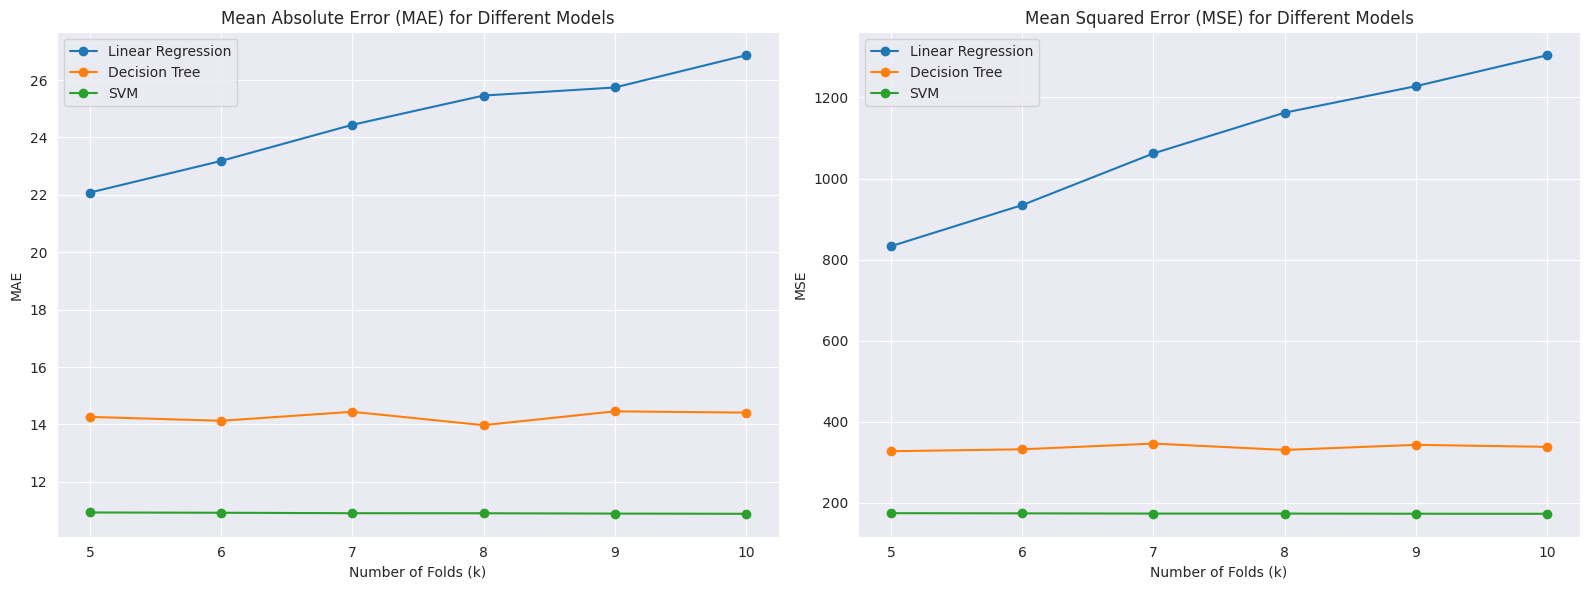

In [ ]:
# Plotting MAE and MSE in separate plots
plt.figure(figsize=(16, 6))

# MAE Plot
plt.subplot(1, 2, 1)

plt.plot(k_values, lr_maes, label='Linear Regression', marker='o')
plt.plot(k_values, dt_maes, label='Decision Tree', marker='o')
plt.plot(k_values, svm_maes, label='SVM', marker='o')

plt.title('Mean Absolute Error (MAE) for Different Models')
plt.xlabel('Number of Folds (k)')
plt.ylabel('MAE')
plt.legend()

# MSE Plot
plt.subplot(1, 2, 2)

plt.plot(k_values, lr_mses, label='Linear Regression', marker='o')
plt.plot(k_values, dt_mses, label='Decision Tree', marker='o')
plt.plot(k_values, svm_mses, label='SVM', marker='o')

plt.title('Mean Squared Error (MSE) for Different Models')
plt.xlabel('Number of Folds (k)')
plt.ylabel('MSE')
plt.legend()

plt.tight_layout()
plt.show()


Train-Test Split

In [ ]:
import pandas as pd


dataframe = pd.read_csv('features.csv')
x = dataframe.drop('bone_age', axis=1)
y= dataframe['bone_age']

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
linear_model = LinearRegression()
linear_model.fit(x_train.values, y_train.values)
y_pred = linear_model.predict(x_test.values)
mae = mean_absolute_error(y_test.values, y_pred)
print(f"Mean Absolute Error on Test Set: {mae}")


Mean Absolute Error on Test Set: 3.3625322481414748


In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
decision_tree_model = DecisionTreeRegressor(random_state=42)
decision_tree_model.fit(x_train, y_train)


y_pred_decision_tree = decision_tree_model.predict(x_test)
mae_decision_tree = mean_absolute_error(y_test, y_pred_decision_tree)
print(f"Mean Absolute Error (Decision Tree) on Test Set: {mae_decision_tree}")


Mean Absolute Error (Decision Tree) on Test Set: 2.331623931623932


In [ ]:
from sklearn.svm import SVR

svm_model = SVR()
svm_model.fit(x_train, y_train)

y_pred_svm = svm_model.predict(x_test)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
print(f"Mean Absolute Error (SVM) on Test Set: {mae_svm}")

Mean Absolute Error (SVM) on Test Set: 1.5464177688561889


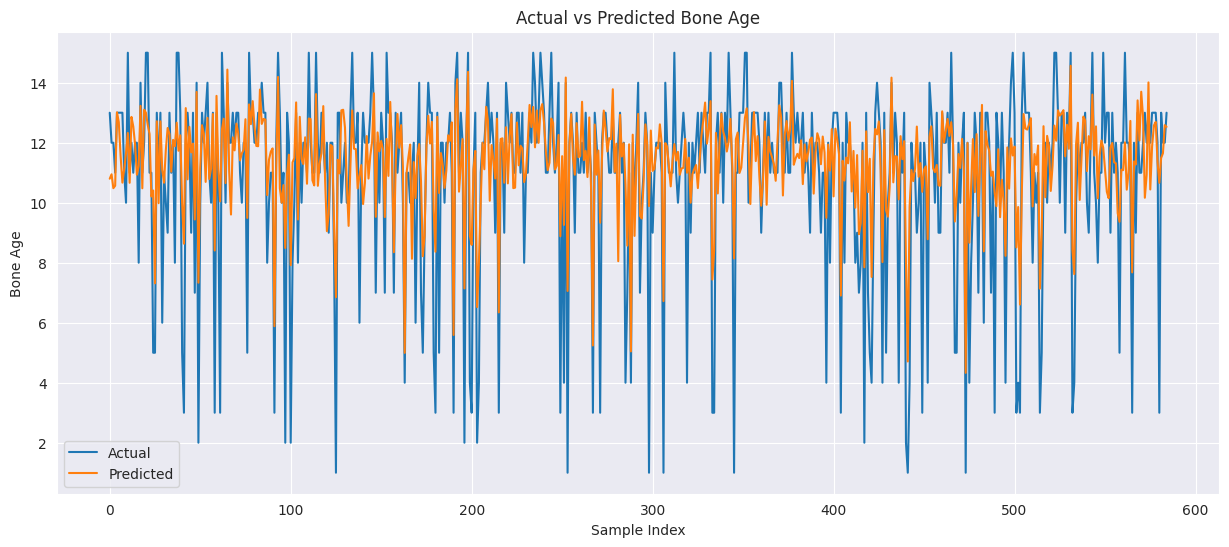

In [ ]:
plt.figure(figsize=(15,6))
plt.plot(y_test.values, label="Actual")
plt.plot(y_pred_svm, label="Predicted")
plt.xlabel("Sample Index")
plt.ylabel("Bone Age")
plt.title("Actual vs Predicted Bone Age")
plt.legend()

plt.show()

In [ ]:
# Print actual and predicted values for the first 10 samples
for i in range(40):
    print(f"Sample {i + 1} - Actual: {y_test.values[i]}, Predicted: {y_pred_svm[i]}")


Sample 1 - Actual: 13, Predicted: 10.800728941373947
Sample 2 - Actual: 12, Predicted: 10.947520820146151
Sample 3 - Actual: 12, Predicted: 10.48452953687048
Sample 4 - Actual: 11, Predicted: 10.566720943837034
Sample 5 - Actual: 13, Predicted: 13.013918202619557
Sample 6 - Actual: 13, Predicted: 12.687134637980897
Sample 7 - Actual: 13, Predicted: 11.563311364917627
Sample 8 - Actual: 13, Predicted: 10.669363042541134
Sample 9 - Actual: 11, Predicted: 11.12828187064112
Sample 10 - Actual: 10, Predicted: 11.656910457881548
Sample 11 - Actual: 15, Predicted: 12.32479844322966
Sample 12 - Actual: 11, Predicted: 10.664769131384334
Sample 13 - Actual: 12, Predicted: 12.860272893148725
Sample 14 - Actual: 11, Predicted: 12.543245404926491
Sample 15 - Actual: 12, Predicted: 11.9447257537363
Sample 16 - Actual: 12, Predicted: 10.93464332085112
Sample 17 - Actual: 8, Predicted: 11.224217565086954
Sample 18 - Actual: 14, Predicted: 13.230242188383464
Sample 19 - Actual: 11, Predicted: 10.480976

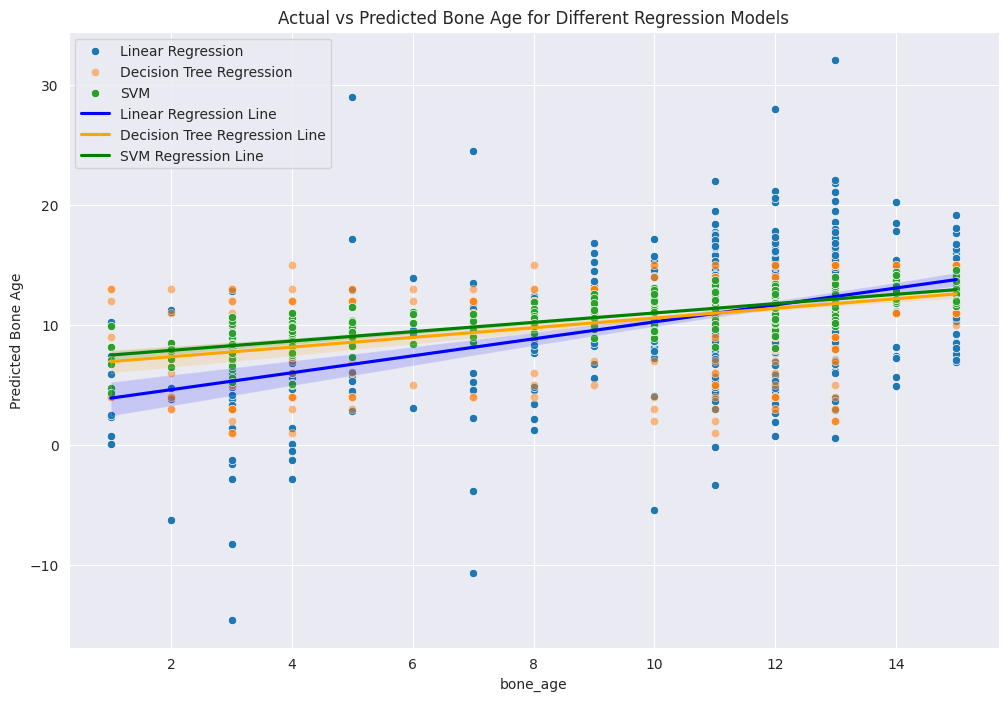

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot of actual vs predicted values for Linear Regression
plt.figure(figsize=(12, 8))
sns.scatterplot(x=y_test, y=y_pred, label="Linear Regression")

# Scatter plot of actual vs predicted values for Decision Tree Regression
sns.scatterplot(x=y_test, y=y_pred_decision_tree, label="Decision Tree Regression", alpha=0.5)
sns.scatterplot(x=y_test,y=y_pred_svm,label='SVM')

plt.xlabel("Actual Bone Age")
plt.ylabel("Predicted Bone Age")
plt.title("Actual vs Predicted Bone Age for Different Regression Models")

# Plotting the regression lines
sns.regplot(x=y_test, y=y_pred, scatter=False, color='blue', label='Linear Regression Line')
sns.regplot(x=y_test, y=y_pred_decision_tree, scatter=False, color='orange', label='Decision Tree Regression Line')
sns.regplot(x=y_test,y=y_pred_svm,scatter=False,color='green',label='SVM Regression Line')
plt.legend()
plt.show()


FEATURE IMPORTANCES TOP 100 FEATURES

In [ ]:
data = pd.read_csv("features.csv")

In [ ]:
data.head()

,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_4087,feature_4088,feature_4089,feature_4090,feature_4091,feature_4092,feature_4093,feature_4094,feature_4095,bone_age
0,0.0,2.584806,0.421358,0.000000,2.503055,0.000000,3.509210,0.0,0.0,3.588813,...,0.0,0.0,0.0,3.008626,0.0,0.0,1.157331,0.0,3.259849,7
1,0.0,2.291984,0.000000,0.000000,2.502975,1.005844,1.339780,0.0,0.0,0.000000,...,0.0,0.0,0.0,3.636118,0.0,0.0,0.000000,0.0,0.000000,12
2,0.0,0.000000,0.000000,2.497637,2.668148,0.000000,4.166633,0.0,0.0,6.355436,...,0.0,0.0,0.0,2.455571,0.0,0.0,1.855213,0.0,0.680956,15
3,0.0,0.000000,0.000000,0.000000,1.008595,0.000000,1.158546,0.0,0.0,6.423346,...,0.0,0.0,0.0,4.561150,0.0,0.0,0.000000,0.0,2.342388,3
4,0.0,0.132166,1.479385,0.000000,4.484186,1.030216,2.890801,0.0,0.0,2.326230,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,1.224508,15


In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import pickle

x = data.drop(columns = ['bone_age'])
y = data['bone_age']
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(x, y)
with open('features.pickle','wb') as to_write:
    pickle.dump(model, to_write)

In [ ]:
feature_importances = model.feature_importances_
feature_importances_df = pd.DataFrame({'Feature': x.columns, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values(by='Importance', ascending=False)

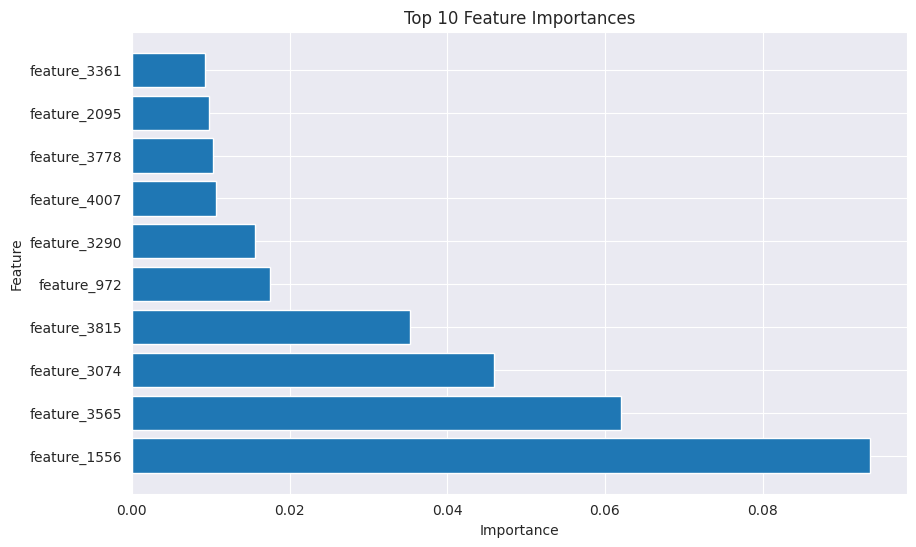

In [ ]:
top_n = 10
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_df['Feature'][:top_n], feature_importances_df['Importance'][:top_n])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top {} Feature Importances'.format(top_n))
plt.show()

In [ ]:
feature_importances_df.head(100)

,Feature,Importance
1556,feature_1556,0.093631
3565,feature_3565,0.062094
3074,feature_3074,0.045875
3815,feature_3815,0.035327
972,feature_972,0.017500
...,...,...
3843,feature_3843,0.001147
2945,feature_2945,0.001143
974,feature_974,0.001143
3547,feature_3547,0.001128


In [ ]:
feature_importances_df.shape

(4096, 2)

In [ ]:
impf=[]
for i in range(len(feature_importances)):
  if feature_importances[i]>=0.001125:
    impf.append('feature_'+str(i))

print(impf)

['feature_9', 'feature_24', 'feature_72', 'feature_99', 'feature_234', 'feature_260', 'feature_336', 'feature_352', 'feature_563', 'feature_571', 'feature_595', 'feature_680', 'feature_711', 'feature_732', 'feature_755', 'feature_757', 'feature_789', 'feature_817', 'feature_844', 'feature_909', 'feature_931', 'feature_937', 'feature_959', 'feature_972', 'feature_974', 'feature_1012', 'feature_1038', 'feature_1060', 'feature_1093', 'feature_1127', 'feature_1167', 'feature_1223', 'feature_1284', 'feature_1437', 'feature_1484', 'feature_1503', 'feature_1528', 'feature_1546', 'feature_1556', 'feature_1715', 'feature_1755', 'feature_1782', 'feature_1806', 'feature_1817', 'feature_1845', 'feature_1895', 'feature_1917', 'feature_1939', 'feature_1950', 'feature_2095', 'feature_2148', 'feature_2312', 'feature_2314', 'feature_2351', 'feature_2370', 'feature_2412', 'feature_2415', 'feature_2638', 'feature_2652', 'feature_2679', 'feature_2736', 'feature_2819', 'feature_2945', 'feature_3005', 'feat

In [ ]:
x1=x[impf]

In [ ]:
y= dataframe['bone_age']

from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(x1,y,test_size=0.2,random_state=42)

In [ ]:
from sklearn.svm import SVR

svm_model = SVR()
svm_model.fit(x_train, y_train)

y_pred_svm = svm_model.predict(x_test)
mae_svm = mean_absolute_error(y_test, y_pred_svm)
print(f"Mean Absolute Error (SVM) on Test Set: {mae_svm}")

Mean Absolute Error (SVM) on Test Set: 1.4291105816454188


In [ ]:
for i in range(20):
    print(f"Sample {i + 1} - Actual: {y_test.values[i]}, Predicted: {y_pred_svm[i]}")


Sample 1 - Actual: 13, Predicted: 10.593748160951879
Sample 2 - Actual: 12, Predicted: 11.258182950981173
Sample 3 - Actual: 12, Predicted: 10.929139105451844
Sample 4 - Actual: 11, Predicted: 10.338217382177907
Sample 5 - Actual: 13, Predicted: 13.083997913113425
Sample 6 - Actual: 13, Predicted: 12.544975599584674
Sample 7 - Actual: 13, Predicted: 11.513629679758758
Sample 8 - Actual: 13, Predicted: 10.021300034962874
Sample 9 - Actual: 11, Predicted: 11.120596715544085
Sample 10 - Actual: 10, Predicted: 12.206366696831417
Sample 11 - Actual: 15, Predicted: 13.56979839134127
Sample 12 - Actual: 11, Predicted: 9.796489133527118
Sample 13 - Actual: 12, Predicted: 12.339881596139929
Sample 14 - Actual: 11, Predicted: 12.324070166015332
Sample 15 - Actual: 12, Predicted: 11.986151420715474
Sample 16 - Actual: 12, Predicted: 10.739695703152332
Sample 17 - Actual: 8, Predicted: 10.934344570120594
Sample 18 - Actual: 14, Predicted: 12.956961628875604
Sample 19 - Actual: 11, Predicted: 9.998

In [ ]:
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

lr=LinearRegression()
dt=DecisionTreeRegressor()
svm=SVR()

k_values=range(5,11)
def calculate_metrics(model,x,y,k):
  kf=KFold(n_splits=k,shuffle=True,random_state=42)
  mae_scores=-cross_val_score(model,x,y,cv=kf,scoring='neg_mean_absolute_error')
  mse_scores=-cross_val_score(model,x,y,cv=kf,scoring='neg_mean_squared_error')
  return np.mean(mae_scores),np.mean(mse_scores)

lr_maes=[]
lr_mses=[]
dt_maes=[]
dt_mses=[]
svm_maes=[]
svm_mses=[]
print("Model\t\t\tK\t\tMAE\t\t\tMSE")
for k in k_values:
  lr_mae,lr_mse=calculate_metrics(lr,x1,y,k)
  dt_mae,dt_mse=calculate_metrics(dt,x1,y,k)
  svm_mae,svm_mse=calculate_metrics(svm,x1,y,k)
  lr_maes.append(lr_mae)
  lr_mses.append(lr_mse)
  dt_maes.append(dt_mae)
  dt_mses.append(dt_mse)
  svm_maes.append(svm_mae)
  svm_mses.append(svm_mse)


  print(f"Linear Regression\t{k}\t\t{lr_mae:.2f}\t\t{lr_mse:.2f}")
  print(f"Decision Tree\t\t{k}\t\t{dt_mae:.2f}\t\t{dt_mse:.2f}")
  print(f"SVM\t\t\t{k}\t\t{svm_mae:.2f}\t\t{svm_mse:.2f}")
  print("-"*40)



Model			K		MAE			MSE
Linear Regression	5		1.57		4.17
Decision Tree		5		2.12		9.93
SVM			5		1.45		3.93
----------------------------------------
Linear Regression	6		1.57		4.19
Decision Tree		6		2.12		9.62
SVM			6		1.44		3.92
----------------------------------------
Linear Regression	7		1.57		4.16
Decision Tree		7		2.13		9.75
SVM			7		1.44		3.91
----------------------------------------
Linear Regression	8		1.57		4.14
Decision Tree		8		2.11		9.11
SVM			8		1.44		3.90
----------------------------------------
Linear Regression	9		1.57		4.17
Decision Tree		9		2.25		10.20
SVM			9		1.44		3.91
----------------------------------------
Linear Regression	10		1.57		4.16
Decision Tree		10		2.14		10.01
SVM			10		1.44		3.90
----------------------------------------
